# **Scalable Music Recommendation Using Apache Spark**

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar -xzf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("UserAnalytics").getOrCreate()

print("Spark is ready!")



Spark is ready!


#**Load the CSV in PySpark**



In [2]:
df = spark.read.csv("/Last.fm_data.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)


root
 |-- _c0: integer (nullable = true)
 |-- Username: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Track: string (nullable = true)
 |-- Album: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)

+---+--------+---------------+--------------------+--------------------+-----------+------+
|_c0|Username|         Artist|               Track|               Album|       Date|  Time|
+---+--------+---------------+--------------------+--------------------+-----------+------+
|  0| Babs_05|Isobel Campbell|The Circus Is Lea...|Ballad of the Bro...|31 Jan 2021| 23:36|
|  1| Babs_05|Isobel Campbell|        Dusty Wreath|Ballad of the Bro...|31 Jan 2021| 23:32|
|  2| Babs_05|Isobel Campbell|Honey Child What ...|Ballad of the Bro...|31 Jan 2021| 23:28|
|  3| Babs_05|Isobel Campbell|It's Hard To Kill...|Ballad of the Bro...|31 Jan 2021| 23:25|
|  4| Babs_05|Isobel Campbell|     Saturday's Gone|Ballad of the Bro...|31 Jan 2021| 23:21

# **ETL**

In [3]:
# Drop index column and clean names
df = df.drop("_c0") \
       .withColumnRenamed("Username", "user_id") \
       .withColumnRenamed("Artist", "artist_name") \
       .withColumnRenamed("Track", "track_name") \
       .withColumnRenamed("Album", "album_name") \
       .withColumnRenamed("Date", "date") \
       .withColumnRenamed("Time", "time")

df.show(5)



+-------+---------------+--------------------+--------------------+-----------+------+
|user_id|    artist_name|          track_name|          album_name|       date|  time|
+-------+---------------+--------------------+--------------------+-----------+------+
|Babs_05|Isobel Campbell|The Circus Is Lea...|Ballad of the Bro...|31 Jan 2021| 23:36|
|Babs_05|Isobel Campbell|        Dusty Wreath|Ballad of the Bro...|31 Jan 2021| 23:32|
|Babs_05|Isobel Campbell|Honey Child What ...|Ballad of the Bro...|31 Jan 2021| 23:28|
|Babs_05|Isobel Campbell|It's Hard To Kill...|Ballad of the Bro...|31 Jan 2021| 23:25|
|Babs_05|Isobel Campbell|     Saturday's Gone|Ballad of the Bro...|31 Jan 2021| 23:21|
+-------+---------------+--------------------+--------------------+-----------+------+
only showing top 5 rows



# **Analysis**

In [4]:
# Top 10 Most Played Artists
from pyspark.sql.functions import count

df.groupBy("artist_name") \
  .agg(count("*").alias("total_plays")) \
  .orderBy("total_plays", ascending=False) \
  .show(10, truncate=False)


+------------+-----------+
|artist_name |total_plays|
+------------+-----------+
|Sophie      |1181       |
|Madlib      |1074       |
|Bicep       |766        |
|Taylor Swift|649        |
|Arlo Parks  |593        |
|Morrissey   |498        |
|Depeche Mode|469        |
|Coldplay    |393        |
|New Order   |367        |
|MF DOOM     |366        |
+------------+-----------+
only showing top 10 rows



In [5]:
#Most Active Users
df.groupBy("user_id") \
  .agg(count("*").alias("total_listens")) \
  .orderBy("total_listens", ascending=False) \
  .show(10, truncate=False)


+----------+-------------+
|user_id   |total_listens|
+----------+-------------+
|Babs_05   |33695        |
|franhale  |32712        |
|Knapster01|27015        |
|eartle    |20966        |
|massdosage|19015        |
|jonocole  |17230        |
|Orlenay   |10123        |
|isaac     |1780         |
|mremond   |1452         |
|jajo      |1102         |
+----------+-------------+
only showing top 10 rows



In [14]:
from pyspark.sql.functions import concat_ws, to_timestamp, regexp_replace

# Make sure column names are lowercase if already renamed
df = df.withColumn("datetime_str", regexp_replace(concat_ws(" ", "date", "time"), " +", " "))
df = df.withColumn("timestamp", to_timestamp("datetime_str", "dd MMM yyyy HH:mm"))

In [15]:
from pyspark.sql.functions import hour, col, count

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df_valid = df.filter(col("timestamp").isNotNull())

df_valid.groupBy(hour("timestamp").alias("hour")) \
  .agg(count("*").alias("activity_count")) \
  .orderBy("hour") \
  .show(24)


+----+--------------+
|hour|activity_count|
+----+--------------+
|   0|          4233|
|   1|          3530|
|   2|          3286|
|   3|          3114|
|   4|          2701|
|   5|          2548|
|   6|          2688|
|   7|          2745|
|   8|          3676|
|   9|          4138|
|  10|          6268|
|  11|          7953|
|  12|          7494|
|  13|          8568|
|  14|          8834|
|  15|          9734|
|  16|         10549|
|  17|         10934|
|  18|         11611|
|  19|         10682|
|  20|         10408|
|  21|         10039|
|  22|         10483|
|  23|          9838|
+----+--------------+



# **ALS (Alternating Least Squares) Recommender in PySpark**


In [16]:
# Recommend artists to users based on their play frequency.
from pyspark.ml.feature import StringIndexer


user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index") # Convert user_id and artist_name to numeric IDs
artist_indexer = StringIndexer(inputCol="artist_name", outputCol="artist_index")


df = user_indexer.fit(df).transform(df) # Fit and transform
df = artist_indexer.fit(df).transform(df)


In [17]:
# if you had multiple logs for the same artist by the same user, you could groupBy and sum instead
from pyspark.sql.functions import lit

df = df.withColumn("play_count", lit(1))


In [18]:
from pyspark.sql.functions import sum

df_agg = df.groupBy("user_index", "artist_index") \
           .agg(sum("play_count").alias("play_count"))


# **Training the ALS Model**

In [19]:
# implicitPrefs=True: We're using implicit feedback (play counts, not ratings)
# coldStartStrategy="drop": Avoid recommending items with missing values
# nonnegative=True: Ensures all learned values are ≥ 0


from pyspark.ml.recommendation import ALS

als = ALS(
    userCol="user_index",
    itemCol="artist_index",
    ratingCol="play_count",
    nonnegative=True,
    implicitPrefs=True,
    coldStartStrategy="drop"
)

model = als.fit(df_agg)
print("Model is ready!")

Model is ready!



# **Recommendation**

In [20]:
# This gives the top 10 artists per user, based on predicted preference scores.
user_recs = model.recommendForAllUsers(10)
user_recs.show(10, truncate=False)


+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_index|recommendations                                                                                                                                                                            |
+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|10        |[{1, 0.9745259}, {5, 0.9737707}, {15, 0.97361386}, {62, 0.9732988}, {6, 0.97279334}, {89, 0.9716064}, {47, 0.9707129}, {23, 0.97029626}, {107, 0.96774}, {10, 0.9676074}]                  |
|0         |[{0, 1.0352361}, {4, 1.0341349}, {1, 1.0336918}, {3, 1.0323961}, {2, 1.0323331}, {25, 1.0315053}, {14, 1.0311145}, {476, 1.0305898}, {24, 1.0304471}, {80, 1.0303601}]                  

In [21]:
# You can reverse map artist IDs using the artist_indexer.labels list:
# Re-fit with a different output column name to avoid conflict
artist_indexer_model = StringIndexer(inputCol="artist_name", outputCol="artist_index_tmp").fit(df)

# Just extract the label list — no need to transform again
artist_id_to_name = artist_indexer_model.labels



In [22]:
# Fit the model separately for reverse mapping
from pyspark.ml.feature import StringIndexer

indexer_for_lookup = StringIndexer(inputCol="artist_name", outputCol="artist_index_tmp")
artist_indexer_model = indexer_for_lookup.fit(df)

# Get mapping of index to artist name
artist_id_to_name = artist_indexer_model.labels


In [23]:
# Example: first user’s recommendations
first_user = user_recs.select("recommendations").first()[0]

for artist_index, score in first_user:
    name = artist_id_to_name[int(artist_index)]
    print(f"🎵 {name} — Score: {score:.2f}")


🎵 Madlib — Score: 0.97
🎵 Morrissey — Score: 0.97
🎵 Metric — Score: 0.97
🎵 Tim Hecker — Score: 0.97
🎵 Depeche Mode — Score: 0.97
🎵 Caspian — Score: 0.97
🎵 Ólafur Arnalds — Score: 0.97
🎵 Johann Sebastian Bach — Score: 0.97
🎵 Within Temptation — Score: 0.97
🎵 James Blake — Score: 0.97


# **Visualize Recommendations**

In [24]:

from pyspark.sql.functions import explode

# Explode recommendations into individual rows
flat_recs = user_recs.selectExpr("user_index", "explode(recommendations) as rec") \
                     .select("user_index", "rec.artist_index", "rec.rating")

flat_recs.show(10)


+----------+------------+----------+
|user_index|artist_index|    rating|
+----------+------------+----------+
|        10|           1| 0.9745259|
|        10|           5| 0.9737707|
|        10|          15|0.97361386|
|        10|          62| 0.9732988|
|        10|           6|0.97279334|
|        10|          89| 0.9716064|
|        10|          47| 0.9707129|
|        10|          23|0.97029626|
|        10|         107|   0.96774|
|        10|          10| 0.9676074|
+----------+------------+----------+
only showing top 10 rows



In [26]:
# Map Artist Index Back to Names
# Convert Spark DataFrame to Pandas for easy plotting
flat_recs_pd = flat_recs.toPandas()

# Map artist_index to names
flat_recs_pd["artist_name"] = flat_recs_pd["artist_index"].apply(lambda i: artist_id_to_name[int(i)])

# Count how many times each artist was recommended
top_artists = flat_recs_pd["artist_name"].value_counts().head(10)

# Display as a table
print(top_artists)


artist_name
Madlib                   7
Morrissey                4
Metric                   4
Tim Hecker               4
Depeche Mode             3
Caspian                  3
Ólafur Arnalds           3
Johann Sebastian Bach    3
Within Temptation        3
Sophie                   3
Name: count, dtype: int64


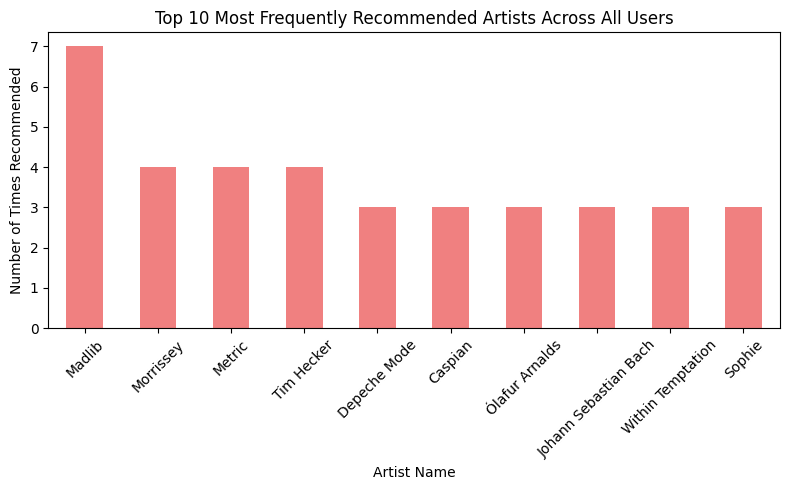

In [28]:
import matplotlib.pyplot as plt

# Plot the bar chart
plt.figure(figsize=(8, 5))
top_artists.plot(kind='bar', color='lightcoral')

plt.title("Top 10 Most Frequently Recommended Artists Across All Users")
plt.xlabel("Artist Name")
plt.ylabel("Number of Times Recommended")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()